In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
! pip install catboost
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay 
import pickle
from pickle import load

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.7 MB/s eta 0:00:00


In [3]:
# Установка опции для отображения всех столбцов
pd.set_option('display.max_columns', None)

# Загрузка

## Датасет заказы

In [4]:
data = pd.read_csv('data.csv')

In [5]:
data = data.drop(data.columns[0], axis=1) # удалили задвоенный индекс

In [6]:
data.head()

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid
0,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
1,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
2,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
3,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
4,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17587 entries, 0 to 17586
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   whs                     17587 non-null  int64  
 1   orderkey                17587 non-null  object 
 2   selected_cartontype     17587 non-null  object 
 3   box_num                 17587 non-null  int64  
 4   recommended_cartontype  17587 non-null  object 
 5   selected_carton         17587 non-null  object 
 6   sel_calc_cube           17587 non-null  int64  
 7   recommended_carton      17587 non-null  object 
 8   pack_volume             17587 non-null  int64  
 9   rec_calc_cube           17587 non-null  int64  
 10  goods_wght              17587 non-null  float64
 11  sku                     17587 non-null  object 
 12  who                     17586 non-null  object 
 13  trackingid              17586 non-null  object 
dtypes: float64(1), int64(5), object(8)
mem

In [ ]:
data.describe()

,whs,box_num,sel_calc_cube,pack_volume,rec_calc_cube,goods_wght
count,325623.000000,325623.000000,325623.000000,3.256230e+05,325623.000000,325623.000000
mean,1.366166,2.787773,11188.402656,5.440790e+03,18253.646168,1.134705
std,2.098641,15.774209,13958.516542,2.858190e+04,26745.365119,4.090043
min,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,1.000000,3449.000000,5.000000e+02,3449.000000,0.110000
50%,0.000000,1.000000,8436.000000,1.192000e+03,8525.000000,0.300000
75%,3.000000,1.000000,15579.000000,3.154000e+03,18270.000000,0.799000
max,7.000000,235.000000,108000.000000,1.815450e+06,108000.000000,153.700000


In [ ]:
# удаляем товары с нулевым весом:
data = data[data['goods_wght'] != 0]

## Датасет Товары

In [ ]:
sku = pd.read_csv('sku.csv')

In [ ]:
sku.head()

,Unnamed: 0,sku,a,b,c
0,0,8ba57dcdba9a58b0c4edd180bef6afc9,11.0,31.0,28.0
1,1,d9af6ce6f9e303f4b1a8cb47cde21975,29.0,14.0,40.0
2,2,8b91fd242bde88f0891380506d9c3caa,12.0,13.0,35.0
3,3,e8af308a7659e34194770d1e3a48e144,3.0,13.0,8.0
4,4,dc0e2542e122731217289b8e6d3bd3f8,96.0,18.0,56.0


## Датасет Категории товаров

In [ ]:
sku_cargotypes = pd.read_csv('sku_cargotypes.csv')

In [ ]:
sku_cargotypes.head()

,Unnamed: 0,sku,cargotype
0,0,4862bf0e760a593b13f3f2fcf822e533,290.0
1,1,4862bf0e760a593b13f3f2fcf822e533,901.0
2,2,50d3c4fc66ad423b7feaadff2d682ee0,290.0
3,3,50d3c4fc66ad423b7feaadff2d682ee0,901.0
4,4,24ce9dba9f301ada55f60e25ee1498d2,290.0


## Датасет Категории

In [ ]:
cargotype_info = pd.read_csv('cargotype_info.csv')

In [ ]:
cargotype_info = cargotype_info.drop(cargotype_info.columns[0], axis=1)

In [ ]:
cargotype_info.head()

,cargotype,description
0,770.0,консервы
1,301.0,тяжеловесный и крупногабаритный 20кг
2,980.0,Требует обязательной маркировки
3,985.0,"Не требует наличия маркировки, но требует выво..."
4,990.0,Потребует обязательной маркировки в ближайшем ...


In [ ]:
# удалим часть информации о карготипах:
values_to_remove = ['цена высокая', 'цена низкая', 'цена средняя', 'возможно вскрытие заводской упаковки покупателем', 
                    'Склад КГТ (крупногабаритный товар)', '2023-04-11', 'Склад СГТ (среднегабаритный товар)', 
                    'Склад МГТ (малогабаритный товар)', 'нельзя примерить', 'большой аксессуар', 'малый аксессуар', 
                    'одежда с плечиками', 'в ассортименте', 'не определен', 'пачкается', 'готовое блюда', 'сыпучее', 'товары народного потребления',
                    'влажный (мокрый)', 'пахучий', 'пачкает', 'сыпучее', 'в ассортименте', 'нельзя примерить', 'упаковка в пленку', 
                    'Требует обязательной маркировки']

cargotype_info = cargotype_info[~cargotype_info['description'].isin(values_to_remove)]

In [ ]:
# Создаем словарь с соответствиями старых категорий и новых категорий
category_mapping_1 = {
    'продукты питания': ['консервы', 'продукты питания'],
    'требующие терморижима': ['скоропортящийся', 'полуфабрикат', 'охлажденные',  'замороженный', 'готовое блюда',
                              'ультра-фреш', 'фреш', 'требует доставки с термо режимом 0+', 'Терморежим 13-22', 
                              'средства личной гигиены', 'семена'],
    'медикаменты':['медикаменты', 'БАДы', 'рецептурное лекарство', 'аптека'],
    'крупногабаритные товары': ['тяжеловесный и крупногабаритный 20кг', 'тяжеловесный и крупногабаритный', 
                                'тяжеловесный и крупногабаритный больше паллеты', 'мебель'],
    'товар +18': ['интим товар', 'возрастное ограничение на получение товара', ],
    'ценности': ['документы и ценные бумаги', 'предметы искусства', 'ценное', 'драгоценности'],
    'электроника':['техника и электроника', 'техника и электроника с литий-ионными батареями', 'цифровой товар', 'бытовая техника', 
                   'электроника'], 
    'продукты химической промышленности':['химикаты', 'опасный', 'пестициды', 'агрохимикаты', 'опасный Авиа', 'аэрозоли и газы',],
    'животные': ['животные', 'меркурий'],
    'товары, требующие особой упаковки': ['мнется', 'хрупкое', 'жидкость', 'керамика/стекло/камень/фарфор'],
    'бытовая химия и косметика': ['косметика и парфюмерия', 'бытовая химия', 'порошки (в том числе мелкодисперсные)', 'товары для красоты'],
    'оружие и взрывчатые вещества': ['оружие и взрывчатые вещества'], 
    'одежда, обувь, аксессуары': ['впитывает запах', 'одежда, обувь, аксессуары', 'обувь взрослая', 'аксессуары, часы и украшения', 'обувь детская',
                                  'одежда верхняя', 'одежда детская', 'одежда прочая'],
    'сырье':['сырье'], 
    'строительные материалы': ['строительные материалы'],
    'товары для животных':['корма для животных', 'товары для животных', 'ветеринарная аптека'],
    'автотовары': ['товары для авто и мототехники']
    }

In [ ]:
# Функция для объединения категорий
def combine_categories(category):
    for new_category, old_categories in category_mapping_1.items():
        if category in old_categories:
            return new_category
    return 'прочее'  # Если категория не входит в объединенные категории, присваиваем "Прочее"

In [ ]:
cargotype_info['total_category'] = cargotype_info['description'].map(combine_categories)

In [ ]:
# Создаем словарь для определения категории перевозки:
category_mapping_2 = {
    'требует раздельной перевозки': ['консервы', 'продукты питания'],
    'экспресс-доставка': ['охлажденные', 'готовое блюда', 'скоропортящийся', 'ультра-фреш', 'фреш'],
    'продукты, требующие отрицательных температур при перевозке':['полуфабрикат', 'замороженный'],
    'прочие товары, требующие перевозки с терморежимом': ['требует доставки с термо режимом 0+', 'Терморежим 13-22', 'медикаменты', 'средства личной гигиены',
                                                          'БАДы', 'рецептурное лекарство', 'семена', 'аптека', 'ветеринарная аптека'],
    'крупногабаритный груз': ['тяжеловесный и крупногабаритный 20кг', 'тяжеловесный и крупногабаритный', 'тяжеловесный и крупногабаритный больше паллеты'
                              'мебель', 'строительные материалы'],
    'перевозка через ФГУП "спецсвязь"': ['документы и ценные бумаги', 'предметы искусства', 'ценное', 'драгоценности', 'оружие и взрывчатые вещества',
                                         ],
    'авиаперевозка': ['техника и электроника с литий-ионными батареями', 'опасный Авиа', 'аэрозоли и газы',],
    'перевозка через систему меркурий': ['животные', 'меркурий'],
    'отдельная перевозка первичного сырья':['сырье'],
    'перевозка автотоваров': ['товары для авто и мототехники']}

In [ ]:
# Функция для объединения категорий
def combine_categories_1(category):
    for new_category, old_categories in category_mapping_2.items():
        if category in old_categories:
            return new_category
    return 'не требует особых правил перевозки'  

In [ ]:
cargotype_info['transportation rules'] = cargotype_info['description'].map(combine_categories_1)

In [ ]:
cargotype_info

,cargotype,description,total_category,transportation rules
0,770.0,консервы,продукты питания,требует раздельной перевозки
1,301.0,тяжеловесный и крупногабаритный 20кг,крупногабаритные товары,крупногабаритный груз
3,985.0,"Не требует наличия маркировки, но требует выво...",прочее,не требует особых правил перевозки
4,990.0,Потребует обязательной маркировки в ближайшем ...,прочее,не требует особых правил перевозки
5,910.0,интим товар,товар +18,не требует особых правил перевозки
...,...,...,...,...
88,801.0,товары для животных,товары для животных,не требует особых правил перевозки
90,670.0,товары для авто и мототехники,автотовары,перевозка автотоваров
91,901.0,аптека,медикаменты,"прочие товары, требующие перевозки с терморежимом"
93,640.0,электроника,электроника,не требует особых правил перевозки


## Датасет Характеристика упаковки

In [ ]:
carton = pd.read_csv('carton.csv')

In [ ]:
carton.drop(['DISPLAYRFPACK'], axis = 1, inplace=True)

In [ ]:
carton

,CARTONTYPE,LENGTH,WIDTH,HEIGHT
0,YMA,24.7,15.0,10.00
1,YMC,30.0,20.0,15.00
2,YME,30.0,30.0,44.50
3,YMF,35.0,25.0,15.00
4,YMG,44.7,30.0,20.00
5,YMH,42.0,20.0,86.00
6,YMJ,50.0,29.0,48.00
7,KSD,0.0,0.0,0.00
8,YML,60.0,40.0,45.00
9,YMN,60.0,60.0,40.00


In [ ]:
carton.rename(columns={'CARTONTYPE': 'selected_carton'}, inplace=True)

## Датасет Цена упаковки

In [ ]:
carton_price = pd.read_excel('carton_price.xlsx')

In [ ]:
carton_price

,Unnamed: 0,01.03.2023
0,MYA,1.109861
1,MYB,2.297432
2,MYC,3.616713
3,MYD,6.918375
4,MYE,8.062722
5,MYF,4.083130
6,YMA,4.392937
7,YMC,7.777487
8,YME,23.670260
9,YMF,10.661487


In [ ]:
carton_price.rename(columns={'Unnamed: 0': 'selected_carton'}, inplace=True)

# Объединение

Сначала создадим общий датафрейм для товара:

In [ ]:
total_sku = sku.merge(sku_cargotypes, how='inner', on='sku').merge(cargotype_info, how='inner', on = 'cargotype')

In [ ]:
total_sku.head()

,Unnamed: 0_x,sku,a,b,c,Unnamed: 0_y,cargotype,description,total_category,transportation rules
0,0,8ba57dcdba9a58b0c4edd180bef6afc9,11.0,31.0,28.0,4575839,200.0,техника и электроника,электроника,не требует особых правил перевозки
1,2,8b91fd242bde88f0891380506d9c3caa,12.0,13.0,35.0,4575844,200.0,техника и электроника,электроника,не требует особых правил перевозки
2,4,dc0e2542e122731217289b8e6d3bd3f8,96.0,18.0,56.0,4575849,200.0,техника и электроника,электроника,не требует особых правил перевозки
3,5,156600848b3684586e60feb0389f95e6,60.0,98.0,12.0,4575856,200.0,техника и электроника,электроника,не требует особых правил перевозки
4,9,f75d4778671e8de9e39c6402ec1b9494,81.0,51.0,14.0,4575874,200.0,техника и электроника,электроника,не требует особых правил перевозки


In [ ]:
total_sku.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1, inplace=True)

In [ ]:
total_sku

,sku,a,b,c,cargotype,description,total_category,transportation rules
0,8ba57dcdba9a58b0c4edd180bef6afc9,11.0,31.0,28.0,200.0,техника и электроника,электроника,не требует особых правил перевозки
1,8b91fd242bde88f0891380506d9c3caa,12.0,13.0,35.0,200.0,техника и электроника,электроника,не требует особых правил перевозки
2,dc0e2542e122731217289b8e6d3bd3f8,96.0,18.0,56.0,200.0,техника и электроника,электроника,не требует особых правил перевозки
3,156600848b3684586e60feb0389f95e6,60.0,98.0,12.0,200.0,техника и электроника,электроника,не требует особых правил перевозки
4,f75d4778671e8de9e39c6402ec1b9494,81.0,51.0,14.0,200.0,техника и электроника,электроника,не требует особых правил перевозки
...,...,...,...,...,...,...,...,...
5709528,559f26db36a110ae872084373d394221,10.0,10.0,10.0,907.0,рецептурное лекарство,медикаменты,"прочие товары, требующие перевозки с терморежимом"
5709529,a59882a4c32d3f9909c41a208a55fc41,11.0,1.0,5.0,907.0,рецептурное лекарство,медикаменты,"прочие товары, требующие перевозки с терморежимом"
5709530,de2c4d3eb34f8ca16a42c50c2fd0d215,11.0,1.0,5.0,907.0,рецептурное лекарство,медикаменты,"прочие товары, требующие перевозки с терморежимом"
5709531,90dd4ffe3ee8e5a3b0363506a663a342,10.0,10.0,10.0,907.0,рецептурное лекарство,медикаменты,"прочие товары, требующие перевозки с терморежимом"


Теперь к датасету с заказами добавим новые сведения:

In [ ]:
df = data.merge(total_sku, how='inner', on ='sku')

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515419 entries, 0 to 767126
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   whs                     515419 non-null  int64  
 1   orderkey                515419 non-null  object 
 2   selected_cartontype     515419 non-null  object 
 3   box_num                 515419 non-null  int64  
 4   recommended_cartontype  515419 non-null  object 
 5   selected_carton         515419 non-null  object 
 6   sel_calc_cube           515419 non-null  int64  
 7   recommended_carton      515419 non-null  object 
 8   pack_volume             515419 non-null  int64  
 9   rec_calc_cube           515419 non-null  int64  
 10  goods_wght              515419 non-null  float64
 11  sku                     515419 non-null  object 
 12  who                     515419 non-null  object 
 13  trackingid              515419 non-null  object 
 14  a                   

# Новые признаки

In [ ]:
#количество товаров в заказе
df.loc[:, 'items_in_order'] = df.groupby('orderkey')['sku'].transform('nunique')

# Удаление лишней информации

In [ ]:
# удалим информацию об id:
df.drop(['whs','selected_cartontype', 'recommended_cartontype', 'who', 'trackingid'], axis = 1, inplace = True)

In [ ]:
# Оставить только уникальные значения 'sku' для каждого уникального значения 'orderkey'
df = df[~df.duplicated(subset=['orderkey', 'sku'])]

In [ ]:
df[df['orderkey']== '562306aed686a4c6b6227200d748ea6b']

,orderkey,box_num,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,a,b,c,cargotype,description,total_category,transportation rules,items_in_order
117381,562306aed686a4c6b6227200d748ea6b,5,YMC,9000,YMA,1440,3705,0.120,c19860fdee4b13b7409924de008e9b4d,16.0,10.0,9.0,340.0,не требует упаковки,прочее,не требует особых правил перевозки,6
175018,562306aed686a4c6b6227200d748ea6b,4,MYE,26277,YMG,2000,26820,1.000,3ba984cf07c7dab172256b65731034ae,10.0,20.0,10.0,750.0,продукты питания,продукты питания,требует раздельной перевозки,6
300983,562306aed686a4c6b6227200d748ea6b,4,MYE,26277,YMG,572,26820,0.100,0d579d27c4440caee64db40b6ee1ab7d,11.0,4.0,13.0,340.0,не требует упаковки,прочее,не требует особых правил перевозки,6
567793,562306aed686a4c6b6227200d748ea6b,1,NONPACK,0,YML,12152,108000,6.479,228db087c03a748211a1f5b056f4f58a,28.5,23.3,18.3,750.0,продукты питания,продукты питания,требует раздельной перевозки,6
567809,562306aed686a4c6b6227200d748ea6b,2,NONPACK,0,YME,11500,40050,6.000,63e7d84f885afac82fd3c72a2e5713b1,20.0,23.0,25.0,750.0,продукты питания,продукты питания,требует раздельной перевозки,6
571787,562306aed686a4c6b6227200d748ea6b,3,NONPACK,0,YMG,12612,26820,6.454,5583bff21dcd931c8572c5b624edaa60,19.6,23.4,27.5,750.0,продукты питания,продукты питания,требует раздельной перевозки,6


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164349 entries, 0 to 767124
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   orderkey              164349 non-null  object 
 1   box_num               164349 non-null  int64  
 2   selected_carton       164349 non-null  object 
 3   sel_calc_cube         164349 non-null  int64  
 4   recommended_carton    164349 non-null  object 
 5   pack_volume           164349 non-null  int64  
 6   rec_calc_cube         164349 non-null  int64  
 7   goods_wght            164349 non-null  float64
 8   sku                   164349 non-null  object 
 9   a                     164349 non-null  float64
 10  b                     164349 non-null  float64
 11  c                     164349 non-null  float64
 12  cargotype             164349 non-null  float64
 13  description           164349 non-null  object 
 14  total_category        164349 non-null  object 
 15  

In [ ]:
df.isnull().mean()

orderkey                0.0
box_num                 0.0
selected_carton         0.0
sel_calc_cube           0.0
recommended_carton      0.0
pack_volume             0.0
rec_calc_cube           0.0
goods_wght              0.0
sku                     0.0
a                       0.0
b                       0.0
c                       0.0
cargotype               0.0
description             0.0
total_category          0.0
transportation rules    0.0
items_in_order          0.0
dtype: float64

In [ ]:
df.describe()

,box_num,sel_calc_cube,pack_volume,rec_calc_cube,goods_wght,a,b,c,cargotype,items_in_order
count,164349.000000,164349.000000,1.643490e+05,164349.000000,164349.000000,164349.000000,164349.000000,164349.000000,164349.000000,164349.000000
mean,1.169596,9605.980973,4.684590e+03,14454.902172,1.094413,18.957764,12.071272,14.725653,532.383154,2.348849
std,3.086206,11081.554816,1.578355e+04,21316.873202,2.780961,18.758181,10.431500,11.268763,234.515365,3.002221
min,1.000000,0.000000,1.000000e+00,0.000000,0.001000,0.100000,0.010000,0.100000,160.000000,1.000000
25%,1.000000,3449.000000,5.060000e+02,3449.000000,0.125000,8.600000,5.000000,7.000000,340.000000,1.000000
50%,1.000000,8436.000000,1.260000e+03,8436.000000,0.330000,14.000000,9.000000,11.200000,490.000000,1.000000
75%,1.000000,13500.000000,3.600000e+03,15579.000000,0.900000,22.100000,17.000000,19.000000,750.000000,3.000000
max,235.000000,108000.000000,1.815450e+06,108000.000000,88.000000,257.000000,240.000000,200.000000,1010.000000,74.000000


(array([1.58809e+05, 4.66500e+03, 5.43000e+02, 1.54000e+02, 6.40000e+01,
        4.00000e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 7.40000e+01]),
 array([ 1. ,  8.3, 15.6, 22.9, 30.2, 37.5, 44.8, 52.1, 59.4, 66.7, 74. ]),
 <BarContainer object of 10 artists>)

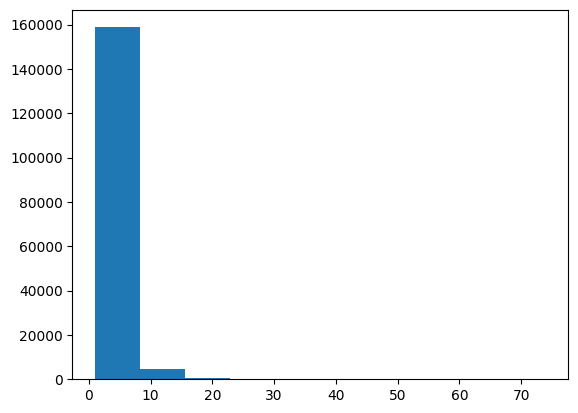

In [ ]:
plt.hist(df['items_in_order'], bins=10) 

<Axes: xlabel='items_in_order'>

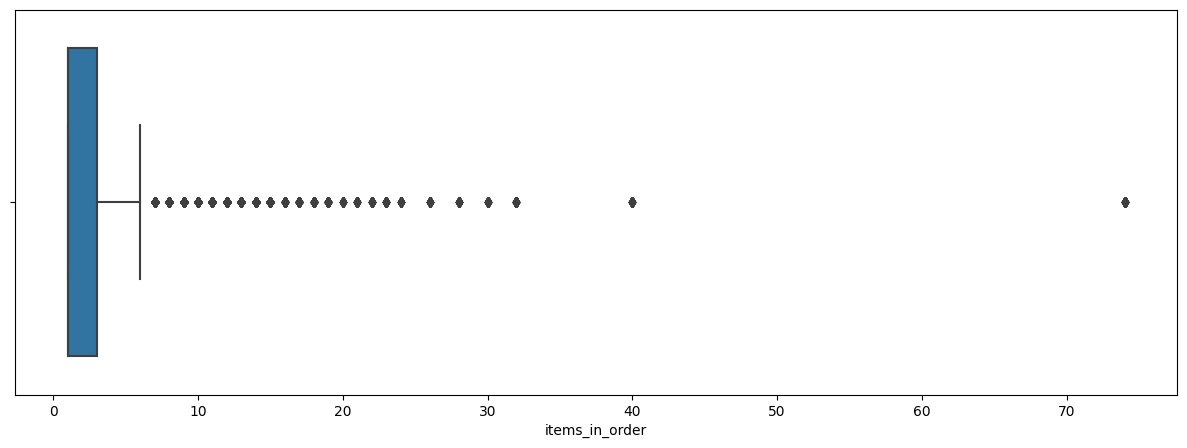

In [ ]:
# Установка размера графика
plt.figure(figsize=(15, 5))  # Здесь (10, 6) - это размеры графика в дюймах (ширина, высота)

# Построение горизонтального боксплота для столбца 'имя_столбца' с использованием seaborn
sns.boxplot(data=df, x='items_in_order', orient='h')

In [ ]:
carton_new = carton.copy()

In [ ]:
carton_new['carton_volume'] = carton_new['LENGTH']*carton_new['WIDTH']*carton_new['HEIGHT']

In [ ]:
# Группировка по 'orderkey' и 'transportation rules' и вычисление суммы 'pack_volume'
df['total_pack_volume'] = df.groupby(['orderkey', 'transportation rules'])['pack_volume'].transform('sum')


In [ ]:
# Вычисление суммы 'pack_volume' с учетом фильтрации по 'description'
df['total_pack_volume_filtered'] = df.loc[df['description'] != 'не требует упаковки'].groupby(['orderkey', 'transportation rules']) \
    ['pack_volume'].transform('sum')

In [ ]:
# добавляем название упаковки
def add_packaging(row):
    product_volume = row['total_pack_volume_filtered']
    matching_cartons = carton_new[carton_new['carton_volume'] >= product_volume]
    if not matching_cartons.empty:
        packaging_volume = matching_cartons['carton_volume'].min()
        packaging_name = carton_new.loc[carton_new['carton_volume'] == packaging_volume, 'selected_carton'].values[0]
    else:
        packaging_name = 'NONPACK'
    return packaging_name

df['packaging'] = df.apply(add_packaging, axis=1)


In [ ]:
df

,orderkey,box_num,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,a,b,c,cargotype,description,total_category,transportation rules,items_in_order,total_pack_volume,total_pack_volume_filtered,packaging
0,4b33fcc98ea1f59d6fe4eb2e0a48bb4b,1,STRETCH,0,MYD,3050,15579,0.896,6287a74b664fd8ad4ed5c541b399a82b,18.6,3.3,49.7,200.0,техника и электроника,электроника,не требует особых правил перевозки,1,3050,3050.0,MYB
1,01277a58f3aa98c06db9046699ec162d,1,MYE,26277,MYD,3050,15579,0.896,6287a74b664fd8ad4ed5c541b399a82b,18.6,3.3,49.7,200.0,техника и электроника,электроника,не требует особых правил перевозки,1,3050,3050.0,MYB
2,19ca05955536663c48d156fdb245576f,1,STRETCH,0,MYD,3050,15579,0.896,6287a74b664fd8ad4ed5c541b399a82b,18.6,3.3,49.7,200.0,техника и электроника,электроника,не требует особых правил перевозки,1,3050,3050.0,MYB
3,e14e21fd406ff6774e69660a492a932a,1,MYE,26277,MYD,3050,15579,0.896,6287a74b664fd8ad4ed5c541b399a82b,18.6,3.3,49.7,200.0,техника и электроника,электроника,не требует особых правил перевозки,1,3050,3050.0,MYB
4,3592b7ae8c3a5c2cb81657356dd6e661,1,MYE,26277,YMX,3050,46800,0.896,6287a74b664fd8ad4ed5c541b399a82b,18.6,3.3,49.7,200.0,техника и электроника,электроника,не требует особых правил перевозки,3,8560,8066.0,MYC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767106,49a255ef0fa15f30c54251d9e386e480,3,NONPACK,0,NONPACK,1617,0,0.430,29dbb42befa2f176eb50828deba50afc,77.0,3.0,6.0,200.0,техника и электроника,электроника,не требует особых правил перевозки,1,1617,1617.0,YMU
767116,379f923b506613b3bd8d3f1bf1cc7092,2,YMW,21812,YMW,6000,21812,0.150,b7ab1a9260ebc1d53774714b24c02dd3,15.0,20.0,20.0,200.0,техника и электроника,электроника,не требует особых правил перевозки,4,14578,6800.0,MYC
767119,2da5e30c36487a43f6b647f1fa223da4,1,MYE,10836,MYE,1400,10836,0.160,ba0b176dc645058663de285b479163b3,50.0,1.0,28.0,340.0,не требует упаковки,прочее,не требует особых правил перевозки,3,5237,NaN,NONPACK
767120,27ac554d4db530391356b9e3125c5f6d,1,MYC,4560,YMC,2688,8525,0.140,0940ce4ed3c65c5713a169bdf824dfcc,28.0,8.0,12.0,340.0,не требует упаковки,прочее,не требует особых правил перевозки,1,2688,NaN,NONPACK


In [ ]:
df['packaging'].nunique()

26

In [ ]:
corr_matrix = df.corr()

<ipython-input-128-b69b4b6a6184>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


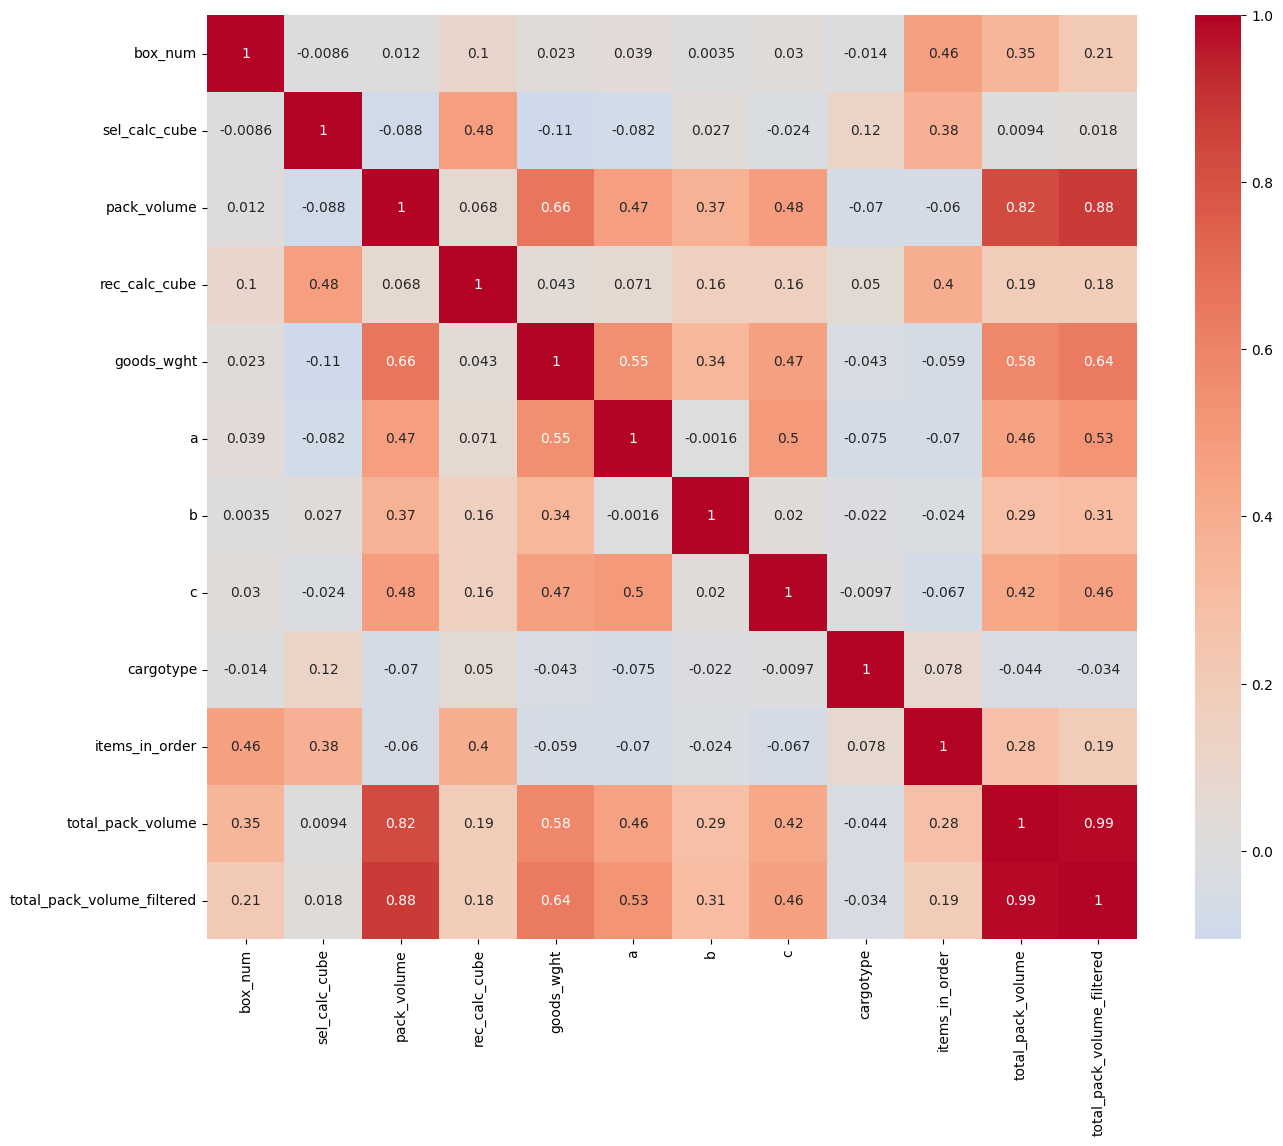

In [ ]:
# Создание тепловой карты
plt.figure(figsize=(15, 12)) 
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.show()

In [ ]:
df_new = df.drop(['box_num', 'sel_calc_cube', 'rec_calc_cube', 'orderkey', 'selected_carton', 'recommended_carton',
                  'sku', 'cargotype', 'total_category', 'total_pack_volume'], axis=1)

In [ ]:
df_new

,pack_volume,goods_wght,a,b,c,description,transportation rules,items_in_order,total_pack_volume_filtered,packaging
0,3050,0.896,18.6,3.3,49.7,техника и электроника,не требует особых правил перевозки,1,3050.0,MYB
1,3050,0.896,18.6,3.3,49.7,техника и электроника,не требует особых правил перевозки,1,3050.0,MYB
2,3050,0.896,18.6,3.3,49.7,техника и электроника,не требует особых правил перевозки,1,3050.0,MYB
3,3050,0.896,18.6,3.3,49.7,техника и электроника,не требует особых правил перевозки,1,3050.0,MYB
4,3050,0.896,18.6,3.3,49.7,техника и электроника,не требует особых правил перевозки,3,8066.0,MYC
...,...,...,...,...,...,...,...,...,...,...
767106,1617,0.430,77.0,3.0,6.0,техника и электроника,не требует особых правил перевозки,1,1617.0,YMU
767116,6000,0.150,15.0,20.0,20.0,техника и электроника,не требует особых правил перевозки,4,6800.0,MYC
767119,1400,0.160,50.0,1.0,28.0,не требует упаковки,не требует особых правил перевозки,3,NaN,NONPACK
767120,2688,0.140,28.0,8.0,12.0,не требует упаковки,не требует особых правил перевозки,1,NaN,NONPACK


In [ ]:
carton_new.rename(columns={'selected_carton': 'packaging'}, inplace=True)

In [ ]:
df_new = df_new.merge(carton_new, how='left', on='packaging')

In [ ]:
df_new=df_new[df_new['items_in_order']<=10]

In [ ]:
df_new

,pack_volume,goods_wght,a,b,c,description,transportation rules,items_in_order,total_pack_volume_filtered,packaging,LENGTH,WIDTH,HEIGHT,carton_volume
0,3050,0.896,18.6,3.3,49.7,техника и электроника,не требует особых правил перевозки,1,3050.0,MYB,22.0,32.0,4.9,3449.6
1,3050,0.896,18.6,3.3,49.7,техника и электроника,не требует особых правил перевозки,1,3050.0,MYB,22.0,32.0,4.9,3449.6
2,3050,0.896,18.6,3.3,49.7,техника и электроника,не требует особых правил перевозки,1,3050.0,MYB,22.0,32.0,4.9,3449.6
3,3050,0.896,18.6,3.3,49.7,техника и электроника,не требует особых правил перевозки,1,3050.0,MYB,22.0,32.0,4.9,3449.6
4,3050,0.896,18.6,3.3,49.7,техника и электроника,не требует особых правил перевозки,3,8066.0,MYC,30.0,38.0,7.4,8436.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164344,1617,0.430,77.0,3.0,6.0,техника и электроника,не требует особых правил перевозки,1,1617.0,YMU,27.0,24.0,4.0,2592.0
164345,6000,0.150,15.0,20.0,20.0,техника и электроника,не требует особых правил перевозки,4,6800.0,MYC,30.0,38.0,7.4,8436.0
164346,1400,0.160,50.0,1.0,28.0,не требует упаковки,не требует особых правил перевозки,3,NaN,NONPACK,0.0,0.0,0.0,0.0
164347,2688,0.140,28.0,8.0,12.0,не требует упаковки,не требует особых правил перевозки,1,NaN,NONPACK,0.0,0.0,0.0,0.0


# Обучение

In [ ]:
# Разделение на признаки (X) и целевой признак (y)
X = df_new.drop('packaging', axis=1)
y = df_new['packaging']

In [ ]:
# Разделение на обучающий и тестовый наборы данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [ ]:
X_train.shape

(112744, 13)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112744 entries, 93734 to 151467
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   pack_volume                 112744 non-null  int64  
 1   goods_wght                  112744 non-null  float64
 2   a                           112744 non-null  float64
 3   b                           112744 non-null  float64
 4   c                           112744 non-null  float64
 5   description                 112744 non-null  object 
 6   transportation rules        112744 non-null  object 
 7   items_in_order              112744 non-null  int64  
 8   total_pack_volume_filtered  100021 non-null  float64
 9   LENGTH                      112744 non-null  float64
 10  WIDTH                       112744 non-null  float64
 11  HEIGHT                      112744 non-null  float64
 12  carton_volume               112744 non-null  float64
dtypes: float64

## Модель

In [ ]:
cat_features = [5, 6]

In [ ]:
# Создание экземпляра LabelEncoder
label_encoder = LabelEncoder()

# Применение Label Encoding к целевой переменной y_train
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
base_model = CatBoostClassifier(
    iterations= 1000, # сколько деревьев в ансамбле
    #learning_rate=0.5, #регурялизация бустинга
    early_stopping_rounds=20, #ограничение на обучение (в данном случае если 20 эпох подряд качество ухудшается модель перестает обучаться)
    loss_function='MultiClass',
    random_seed=42,
    train_dir='base_model',
    verbose=0 #если вербосс = 0, модель не будет выводить на экран процесс обучения
)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_encoded, test_size=0.40, random_state=42)

In [147]:
base_model.fit(
    X_train, y_train,
    cat_features=cat_features, eval_set = (X_val, y_val))

In [148]:
y_pred_proba = base_model.predict_proba(X_test)

In [149]:
# Раскодирование предсказанных вероятностей
y_pred = label_encoder.inverse_transform(np.argmax(y_pred_proba, axis=1))

In [150]:
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba, multi_class='ovr')  # используйте multi_class='ovr' для ROC AUC в мультиклассовой классификации

In [151]:
roc_auc

1.0

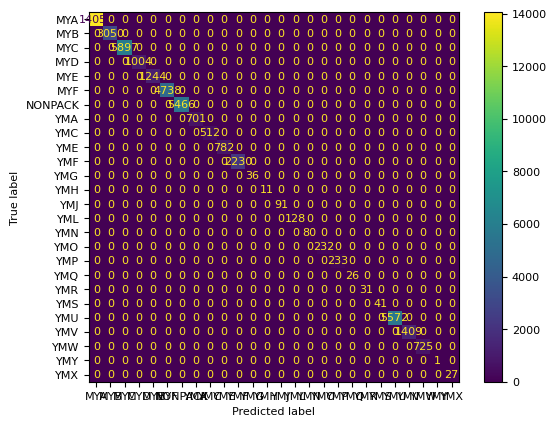

In [152]:
plt.rc('font', size=8)

# Создание матрицы ошибок
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

# Отображение графика
plt.show()

In [ ]:
with open ("file.pcl","bw") as fid
pickle.dump(base_model, "file.pcl")